In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier

In [2]:
def feature_engineering(price, period, window):
    
    X = price.copy()
    mavg = X.rolling(period).mean()
    diff = X - mavg
    for i in range(window):
        X[str(i)] = diff.shift(i)  
    return X.dropna()

In [3]:
def labels(data, minimum, maximum):
    
    labels = []    
    for i in range(data.shape[0] - maximum):
        rand = random.randint(minimum, maximum)
        if data["Close"][i] <= (data["Close"][i + rand]):
            labels.append(0.0)
        else:
            data["Close"][i] >= data["Close"][i + rand]
            labels.append(1.0)
    data = data.iloc[:len(labels)].copy()
    data["y_hat"] = labels
    data = data.dropna()
    return data

In [4]:
def plot_pca(dataset):
    pca = PCA(n_components=0.9)
    components = pd.DataFrame(pca.fit_transform(dataset.iloc[:, 1:-1]))
    components["y_hat"] = dataset["y_hat"].reset_index(drop=True)
    sns.pairplot(data=components, hue="y_hat")
    plt.show();

In [5]:
df = pd.read_csv("data/ethusdt.csv", index_col="datetime")
df.head()

,Close
datetime,
2020-01-01 00:00:00,128.91
2020-01-01 00:15:00,128.78
2020-01-01 00:30:00,128.86
2020-01-01 00:45:00,128.87
2020-01-01 01:00:00,129.13


In [6]:
df = feature_engineering(df, 10, 15)
df = labels(df, 5, 8)
df.head()

,Close,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,y_hat
datetime,,,,,,,,,,,,,,,,,
2020-01-01 05:45:00,130.30,0.048,0.040,0.071,-0.111,-0.166,0.028,-0.235,-0.250,-0.281,-0.367,0.092,-0.027,0.757,0.864,1.058,1.0
2020-01-01 06:00:00,130.48,0.192,0.048,0.040,0.071,-0.111,-0.166,0.028,-0.235,-0.250,-0.281,-0.367,0.092,-0.027,0.757,0.864,1.0
2020-01-01 06:15:00,130.75,0.407,0.192,0.048,0.040,0.071,-0.111,-0.166,0.028,-0.235,-0.250,-0.281,-0.367,0.092,-0.027,0.757,1.0
2020-01-01 06:30:00,130.62,0.237,0.407,0.192,0.048,0.040,0.071,-0.111,-0.166,0.028,-0.235,-0.250,-0.281,-0.367,0.092,-0.027,1.0
2020-01-01 06:45:00,130.44,0.032,0.237,0.407,0.192,0.048,0.040,0.071,-0.111,-0.166,0.028,-0.235,-0.250,-0.281,-0.367,0.092,1.0


C:\Users\Beauj\anaconda3\envs\quantitative_trading\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


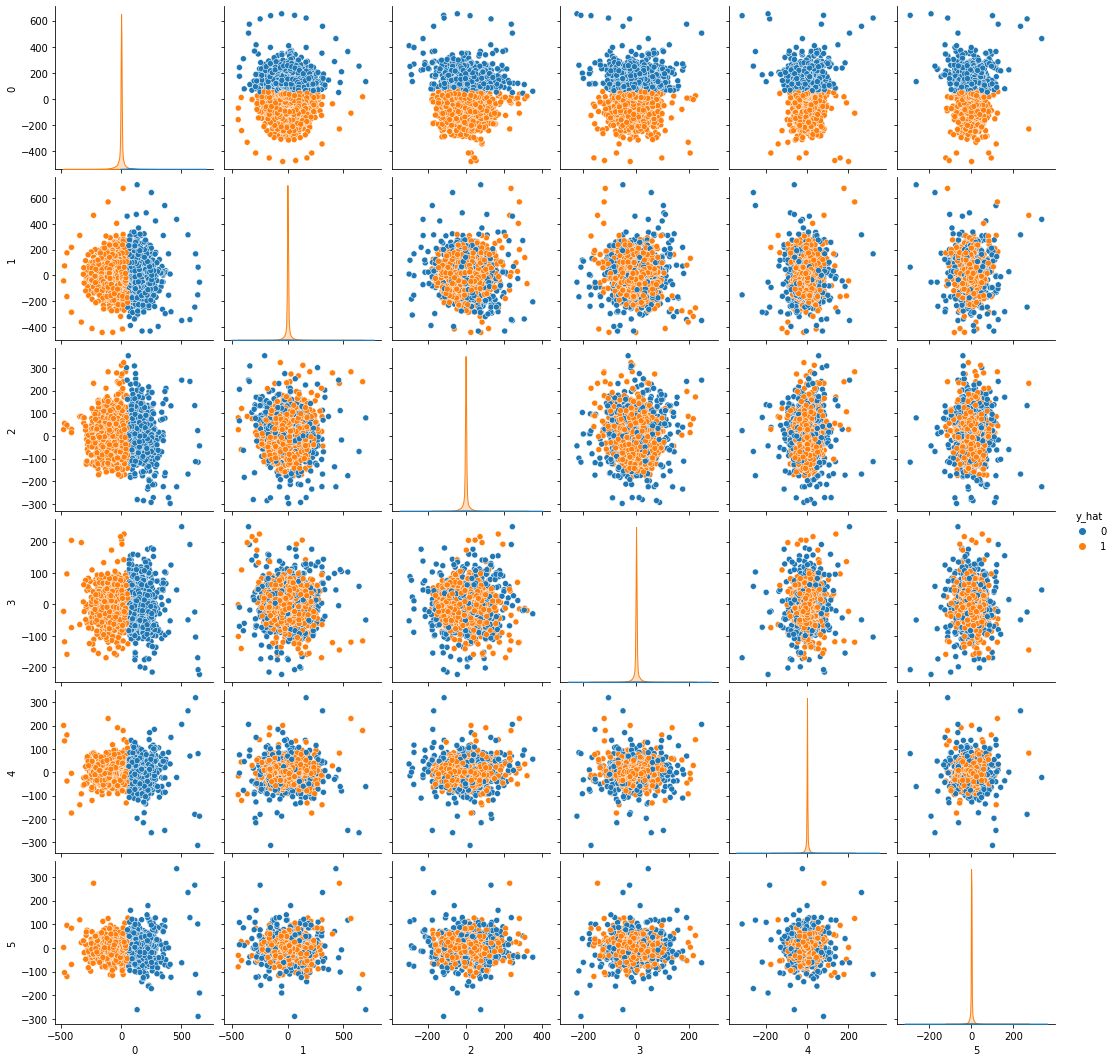

In [7]:
X = df.iloc[:, 1:]
kmeans = KMeans(n_clusters=2, n_jobs=-1)
kmeans.fit(X)
y_hat = kmeans.predict(X)
df2 = df.copy()
df2["y_hat"] = y_hat
plot_pca(df2)

In [8]:
df3 = df.copy()
X = df3.iloc[:, 1:]
gmm = mixture.GaussianMixture(n_components=75)
gmm.fit(X)

C:\Users\Beauj\anaconda3\envs\quantitative_trading\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


GaussianMixture(n_components=75)

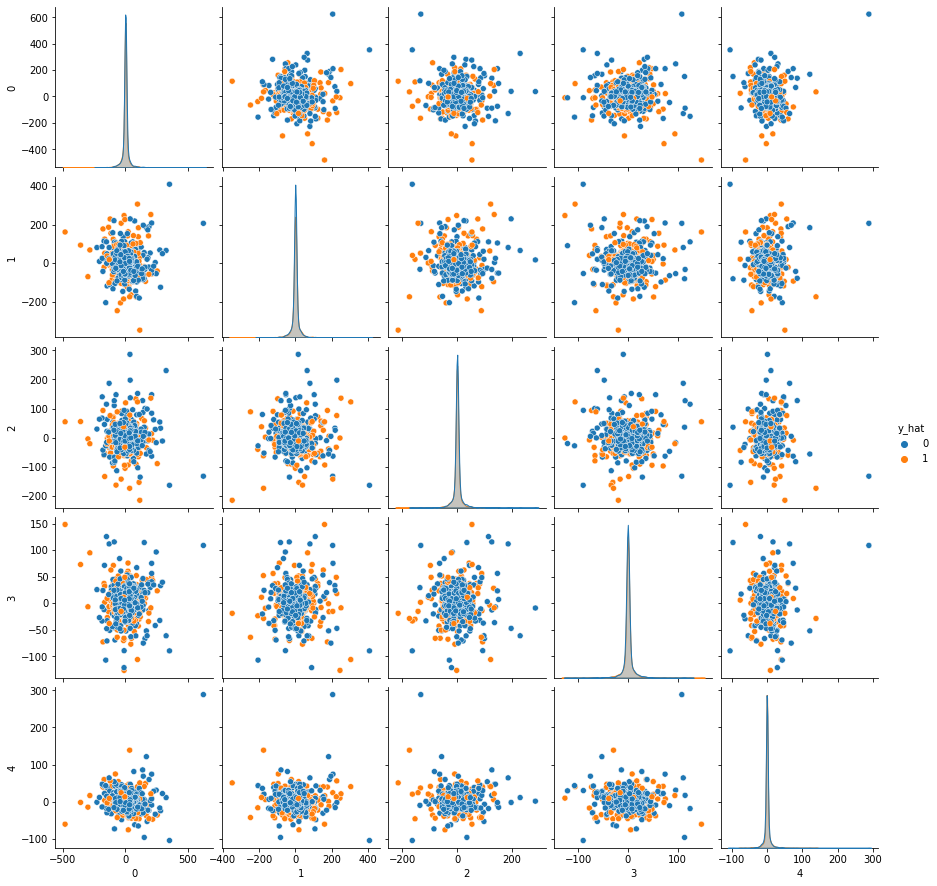

In [9]:
samples = gmm.sample(5000)
samples_df = pd.DataFrame(samples[0])
samples_df.rename(columns={samples_df.columns[-1]: "y_hat"},
                  inplace=True)
samples_df["y_hat"] = np.where(samples_df["y_hat"]>=0.5, 1, 0)
plot_pca(samples_df)

In [10]:
X = samples_df.iloc[:,:-1]
y = samples_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
lgbm_clf = LGBMClassifier(n_estimators=1000,
                          max_depth=7)
lgbm_clf.fit(X_train,
             y_train,
             eval_set=(X_test, y_test),
             early_stopping_rounds=250)

[1]	valid_0's binary_logloss: 0.692245
Training until validation scores don't improve for 250 rounds
[2]	valid_0's binary_logloss: 0.69167
[3]	valid_0's binary_logloss: 0.691103
[4]	valid_0's binary_logloss: 0.691435
[5]	valid_0's binary_logloss: 0.69191
[6]	valid_0's binary_logloss: 0.691442
[7]	valid_0's binary_logloss: 0.691746
[8]	valid_0's binary_logloss: 0.69151
[9]	valid_0's binary_logloss: 0.690941
[10]	valid_0's binary_logloss: 0.692269
[11]	valid_0's binary_logloss: 0.692573
[12]	valid_0's binary_logloss: 0.692095
[13]	valid_0's binary_logloss: 0.692254
[14]	valid_0's binary_logloss: 0.692302
[15]	valid_0's binary_logloss: 0.693291
[16]	valid_0's binary_logloss: 0.694112
[17]	valid_0's binary_logloss: 0.694406
[18]	valid_0's binary_logloss: 0.69489
[19]	valid_0's binary_logloss: 0.694889
[20]	valid_0's binary_logloss: 0.695022
[21]	valid_0's binary_logloss: 0.695043
[22]	valid_0's binary_logloss: 0.694022
[23]	valid_0's binary_logloss: 0.69454
[24]	valid_0's binary_logloss: 0

LGBMClassifier(max_depth=7, n_estimators=1000)

In [11]:
lgbm_clf.score(X_test, y_test)

0.529